In [1]:
import piplite
await piplite.install(['tqdm', 'seaborn', 'skillsnetwork', 'pandas', 'numpy', 'scikit-learn'])

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import skillsnetwork

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [3]:
boston = pickle.load(open('boston_housing_clean.pickle', "rb" ))


In [4]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [5]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [6]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?


## Answer

Firstly you get your training data


Set the number of iterations you want to perform (in this case 3)


For each iteration, divide your data into the training portion and the validation portion


Get the prediction on each validation portion


Calculate the mean squared error for each set of predictions using the test set 


In [7]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [8]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [9]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')


Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [10]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6719348798472712, 0.7485020059212381, 0.6976807323597776]

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?


Firstly you get your training data


Set the number of iterations you want to perform (in this case 3)


For each iteration, divide your data into the training portion and the validation portion

Scale all your data available using Standard Scaler in each iteration


Get the prediction on each validation portion


Calculate the mean squared error for each set of predictions using the test set

In [11]:
#from sklearn.metrics import r2_score, mean_squared_error

scaler = StandardScaler()
scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X.iloc[train_index, :] = scaler.fit_transform(X.iloc[train_index, :] )
    X.iloc[test_index, :] = scaler.fit_transform(X.iloc[test_index, :] )
   
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6747581676036647, 0.7535943098866922, 0.7090778427166065]

### Excerise

In [12]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [13]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", scaler),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [14]:
list(zip(alphas,scores))

[(1e-09, 0.7103271227633787),
 (1e-08, 0.7103271235373381),
 (1e-07, 0.710327131369816),
 (1e-06, 0.7103272086242945),
 (1e-05, 0.7103279852105325),
 (0.0001, 0.7103356970761587),
 (0.001, 0.7104116681603216),
 (0.01, 0.711102027196157),
 (0.1, 0.7102633730887423),
 (1.0, 0.6566965218586881)]

In [15]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-9.37630124e-01,  1.03099727e+00,  1.30758043e-01,  6.82549600e-01,
       -1.94451054e+00,  2.73591250e+00, -1.16167238e-03, -3.04041102e+00,
        2.63706132e+00, -2.11906834e+00, -2.04607444e+00,  8.49577466e-01,
       -3.73056166e+00])

In [16]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.        ,  0.        , -0.        ,  0.00434768, -0.        ,
        2.74956998, -0.        , -0.        , -0.        , -0.        ,
       -1.35203162,  0.18382666, -3.53908122])

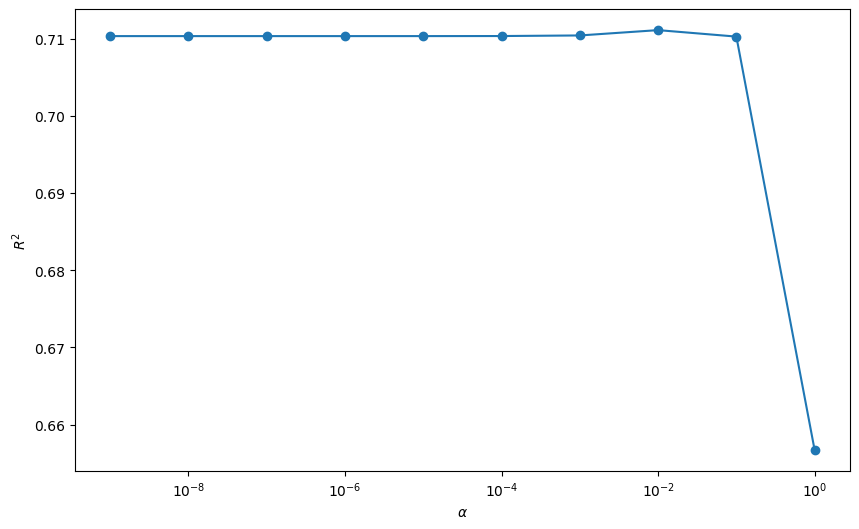

In [17]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

## Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [ ]:
pf = PolynomialFeatures(degree=3)
scores = []
alphas = np.geomspace(1e-5, 1e10, num=15)

for alpha in alphas:
    
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", scaler),
        ("pf",pf),

        ("lasso_regression", las),
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [ ]:
scores